# Mel-Frequency Cepstral Coefficients

Mel-Frequency Cepstral Coefficients(MFCC)는 음성 인식과 관련해 불필요한 정보는 버리고 중요한 특질만 남긴 피처(feature)입니다. MFCC는 [기존 시스템](ttps://ratsgo.github.io/speechbook/docs/am)은 물론 최근 엔드투엔드(end-to-end) 기반 모델에 이르기까지 음성 인식 시스템에 널리 쓰이는 피처인데요. [뉴럴네트워크 기반 피처 추출](ttps://ratsgo.github.io/speechbook/docs/neuralfe) 방식과는 달리 음성 도메인의 지식과 공식에 기반한 피처 추출 방식입니다(**deterministic**). 이번 글에서는 MFCC를 추출하는 방법을 알아봅니다.

---

## Framework

Mel-Frequency Cepstral Coefficients(MFCC)를 만드는 전체 과정을 도식화한 그림은 그림1과 같습니다. MFCC는 입력 음성을 짧은 구간(대개 25ms 내외)으로 나눕니다. 이렇게 잘게 쪼개진 음성을 **프레임(frame)**이라고 합니다. 프레임 각각에 [푸리에 변환(Fourier Transform)](https://ratsgo.github.io/speechbook/docs/fe/ft)을 실시해 해당 구간 음성(frame)에 담긴 주파수(frequency) 정보를 추출합니다. 모든 프레임 각각에 푸리에 변환을 실시한 결과를 **스펙트럼(spectrum)**이라고 합니다.


## **그림1** framework
<img src="https://i.imgur.com/Pn5LGTk.png" width="600px" title="source: imgur.com" />


스펙트럼에 사람의 말소리 인식에 민감한 주파수 영역대는 세밀하게 보고 나머지 영역대는 상대적으로 덜 촘촘히 분석하는 필터(Mel Filter Bank)를 적용합니다. 이를 **멜 스펙트럼(Mel Spectrum)**이라고 합니다. 여기에 로그를 취한 것이 바로 **로그 멜 스펙트럼(log-Mel Spectrum)**입니다. MFCC는 로그 멜 스펙트럼에 역푸리에변환(Inverse Fourier Transform)을 적용해 주파수 도메인의 정보를 새로운 시간(time) 도메인으로 바꾼 것을 가리킵니다. MFCC는 [기존 음성 인식 시스템](https://ratsgo.github.io/speechbook/docs/am/legacy)에서 가우시안 믹스처 모델(Gaussian Mixture Model)의 입력으로 쓰입니다.

MFCC는 인간의 말소리 인식에 중요한 특질들이 추출된 결과입니다. 음성학, 음운론 전문가들이 도메인 지식을 활용해 공식화한 것이라고 볼 수 있겠습니다. 상당히 오랜 시간동안 변화와 발전을 거듭해 그림1과 같은 피처 추출 프레임워크가 탄생하였고 그 성능 또한 검증되었습니다. 최근에는 [뉴럴네트워크에 의한 피처 추출](ttps://ratsgo.github.io/speechbook/docs/neuralfe)도 점점 관심을 받고 있지만, 로그 멜 스펙트럼이나 MFCC는 음성 인식 분야에서 아직까지 널리 쓰이고 있는 피처입니다.


---

## Raw Wave Signal

그럼 이제부터 MFCC 피처를 만드는 과정을 차례대로 살펴보겠습니다. 이 글에 소개된 MFCC 관련 파이썬 코드는 [Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)에서 그대로 인용한 것임을 미리 밝혀둡니다.

음성1은 한국정보화진흥원에서 구축해 2019년 공개한 '한국어음성 데이터'입니다. 조용한 환경에서 2000여명이 발성한 한국어 대화 음성 1000시간짜리 데이터셋인데요. 이 가운데 하나를 wav 파일로 변환해 공유해 드립니다. 재생(➤) 버튼을 누르면 들으실 수 있습니다.

## **음성1** 예시 음성과 전사 스크립트
<audio class="audio" controls preload="none"><source src="https://github.com/ratsgo/speechbook/blob/master/docs/feature_extraction/example.wav?raw=true"></audio>

그래 가지고 그거 연습해야 된다고 이제 빡씨게 모여야 되는데 내일 한 두 시나 네 시에 모여서 저녁 여덟시까지 교회에 있을 거 같애

우선 [위의 파일](https://github.com/ratsgo/speechbook/blob/master/docs/feature_extraction/example.wav?raw=true)을 로컬에 다운로드 받습니다. wav 파일을 읽는 파이썬 코드와 실행 결과는 코드1과 같습니다.


## **코드1** Wave file 읽기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import scipy.io.wavfile
sample_rate, signal = scipy.io.wavfile.read('/content/drive/MyDrive/AI_sound/4.deeplearning_sound/3.feature_extraction/example.wav')

In [11]:
import numpy as np
print(sample_rate)
print(signal)
print(np.min(signal),np.max(signal))
print(type(signal[0]))
print(len(signal))
print(len(signal) / sample_rate)

16000
[36 37 60 ...  7  9  8]
-8398 7379
<class 'numpy.int16'>
183280
11.455


sampling rate(`sample_rate`)는 16000(`16KHz`)입니다. 음성 신호(`signal`)의 `dtype`을 보니 16비트로 양자화(quantization) 되어 있습니다. 다시 말해 실수(real number) 범위의 이산(discrete) 음성 신호가 -32768~32767 범위의 정수(integer)로 변환되었다는 뜻입니다. 실제로 `signal` 변수는 18만3280개 정수들의 시퀀스입니다. sampling rate는 원시 음성 신호를 1초에 몇 번 샘플했는지 나타내는 지표이므로 `signal` 변수 길이를 `sample_rate`로 나누면 입력 음성이 몇 초짜리인지 확인할 수 있습니다(11.455초). 이와 관련해서는 [이 글](https://ratsgo.github.io/speechbook/docs/phonetics/acoustic#digitization)을 참고하시면 좋겠습니다.

이 글에서는 11.455초 길이의 음성에서 초반 3.5초 구간만 잘라서 MFCC를 만들어 보겠습니다. 음성을 3.5초로 자르는 코드는 코드2와 같습니다. 코드2를 수행하면 `signal` 길이가 56000으로 짧아진 것을 볼 수 있습니다.


## **코드2** 음성을 앞에서부터 3.5초로 자름

In [12]:
signal = signal[0:int(3.5 * sample_rate)]

In [13]:
len(signal)

56000

## Preemphasis

사람 말소리를 스펙트럼(spectrum)으로 변환해서 관찰하면 일반적으로 저주파(low frequency) 성분의 에너지(energy)가 고주파(high frequency)보다 많은 경향이 있습니다. 이러한 경향은 모음(vowel)에서 자주 확인됩니다. 고주파 성분의 에너지를 조금 올려주면 음성 인식 모델의 성능을 개선할 수 있다고 합니다. 고주파 성분의 에너지를 올려주는 전처리 과정을 **preemphasis**라고 합니다. preemphasis를 실시하면 다음 세 가지 효과를 볼 수 있다고 합니다.

1. 상대적으로 에너지가 적은 고주파 성분을 강화함으로써 원시 음성 신호가 전체 주파수 영역대에서 비교적 고른 에너지 분포를 갖도록 함.
2. 푸리에 변환시 발생할 수 있는 numerical problem 예방.
3. Signal-to-Noise Ratio(SNR) 개선.

$t$번째 시점의 원시 음성 신호를 $\mathbf{x}_t$라고 할 때 preemphasis는 수식1과 같이 계산합니다(**first-order high-pass filter**). preemphasis coefficient $\alpha$는 보통 0.95나 0.97을 사용한다고 합니다. 예시 음성에 대한 preemphasis 수행 코드와 결과는 코드3에서 확인할 수 있습니다.


## **수식1** Preemphasis
$${ \mathbf{y} }_{ t }={ \mathbf{x} }_{ t }-\alpha { \mathbf{x} }_{ t-1 }$$

## **코드3** Preemphasis

In [14]:
import numpy as np
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [15]:
emphasized_signal

array([  36.  ,    2.08,   24.11, ..., -233.76, -262.5 ,  -61.87])

## Framing

MFCC를 만들 때 푸리에 변환을 실시합니다. 그러면 마치 스냅샷을 찍는 것처럼 해당 음성의 주파수별 정보를 확인할 수 있습니다. 그런데 원시 음성 신호는 아주 빠르게 변화합니다(**non-stationary**). 분석 대상 시간 구간이 지나치게 길 경우 빠르게 변화하는 신호의 주파수 정보를 정확히 캐치하기 어려울 뿐더러 주파수 정보가 전체 시간 구간에 걸쳐 뭉뚱 그려져 음성 인식 모델의 피처로서 제대로 작동하기 어려울 겁니다.

이에 음성 신호가 **stationary**하다고 가정해도 좋을 만큼 원시 음성 신호를 아주 짧은 시간 단위(대개 25ms)로 잘게 쪼갭니다. stationary란 '마치 지속적으로 울리는 사이렌 소리처럼 시점이 변하더라도 해당 신호가 변하지 않는다'는 걸 의미합니다. 이렇게 음성 신호를 짧은 시간 단위로 잘게 쪼개는 과정을 framing이라고 합니다. 코드4는 예시 음성 파일에 framing을 수행하는 코드와 그 수행 결과입니다. framing을 할 때는 프레임을 일정 시간 단위(`frame_size`=25ms)로 자르되 일정 구간(`frame_stride`=10ms)은 겹치도록 합니다. 일정 구간 겹치게 처리하는 것은 바로 다음 파트인 windowing와 연관이 있는데요. 해당 파트에서 설명하도록 하겠습니다.

## **코드4** Framing

In [22]:
np.tile(np.arange(0, 10), (5, 1))

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [24]:
np.tile(np.arange(0, 10), (1, 2))

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [37]:
frame_size = 0.025
frame_stride = 0.01
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
print(signal_length)
print(frame_length)
print(frame_step)
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
print(num_frames)
pad_signal_length = num_frames * frame_step + frame_length
print(pad_signal_length)
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z)
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
          np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T

print(indices.shape)
# print(indices[2])
frames = pad_signal[indices.astype(np.int32, copy=False)]
print(frames.shape)
# print(frames[347])

56000
400
160
348
56080
(348, 400)
(348, 400)


In [35]:
pad_signal

array([36.  ,  2.08, 24.11, ...,  0.  ,  0.  ,  0.  ])

In [38]:
len(pad_signal)

56080

In [41]:
indices[1]

array([160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302,
       303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328,
       329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 34

In [42]:
indices.shape

(348, 400)

In [43]:
frames

array([[  36.  ,    2.08,   24.11, ...,    4.56,    3.74,    2.89],
       [  16.43,  -32.15,  -47.2 , ...,  -13.06,  -16.45,    2.07],
       [  -9.  ,   -9.27,   11.46, ...,   -5.09,   -7.24,   -2.45],
       ...,
       [ 315.7 ,  130.65,  211.81, ..., -121.15,  -17.69, -195.02],
       [ 283.62, 1098.42,  815.34, ...,   20.53,  136.92,  150.79],
       [ -59.03, -212.81, -289.18, ..., -157.35,  -81.12,   24.54]])

In [44]:
frames.shape

(348, 400)

`pad_signal`은 앞서 preemphasis를 수행한 신호(`emphasized_signal`)에 제로 패딩(`z`)를 이어붙인 것입니다. `emphasized_signal`의 길이가 56000이라는 점을 감안하면 여기에 0이 80개 덧붙여진 것을 확인할 수 있습니다. `indices`는 `pad_signal`에서 인덱스(index) 기준으로 값을 참조하려고 만든 변수입니다. 예컨대 `indices`가 [[0, 1], [1, 2]]라면 이로부터 만든 `frames`는 [[36., 2.08], [2.08, 24.11]]이 될 겁니다. `indices`를 자세히 살펴보면 첫번째 프레임을 만드는 데 관여하는 인덱스 범위가 0\~399인데 두번째 프레임에 관련된 범위는 160\~559임을 확인할 수 있습니다. 다시 말해 이전 프레임과 다음 프레임이 서로 겹친다는 의미입니다.

`indices`와 `frames`의 shape는 $348 \times 400$입니다. 후자(400)는 프레임 하나의 길이(`frame_length`)를 의미합니다. 우리는 `frame_size`를 25ms로 정했고 예시 음성의 sampling rate는 16000이므로 이 둘을 곱한 400이 프레임당 길이가 됩니다. 전자(348)는 프레임 개수(`num_frames`)를 가리킵니다. 코드4를 확인해보면 이전 프레임과 다음 프레임 사이의 간격(`frame_step`)과 직접 관련이 있습니다. 결론적으로 framing의 최종 수행 결과는 `frames`이 되는데요. 원시 음성을 짧은 구간(25ms)으로 자르되 일부 구간(10ms)은 겹치게 처리한 것입니다.

---

## Windowing

Windowing이란 각각의 프레임에 특정 함수를 적용해 경계를 스무딩하는 기법입니다. 대표적으로 **해밍 윈도우(Hamming Window)**라는 함수가 있습니다. 그림2와 같습니다. 개별 프레임에 그림2와 같은 해밍 윈도우를 적용하게 되면 프레임 중간에 있는 값들은 1이 곱해져 그대로 살아남고 양 끝 부분은 0에 가까운 값이 곱해져 그 값이 작아집니다. 해밍 윈도우는 수식2, 그림2와 같습니다($n$은 해밍 윈도우 값 인덱스, $N$은 프레임 길이).

## **수식2** Hamming Window
$$w\left[ n \right] =0.54-0.46\cos { \left( \frac { 2\pi n }{ N-1 }  \right)  }$$

## **그림2** Hamming Window
<img src="https://i.imgur.com/tHPxKTg.png" width="400px" title="source: imgur.com" />

해밍 윈도우 함수 같은 Windowing을 적용하는 이유는 그림3에서 유추해볼 수 있습니다. 우리가 앞서 원시 음성 신호를 짧은 구간 단위로 잘게 쪼개는 framing을 수행했는데요. 이는 그림3에서 **Rectangular Window**를 적용한 셈이 됩니다. 그런데 Rectangular Window로 자른 프레임의 양끝에서는 신호가 살아 있다가 갑자기 죽는(=0) 상황이 발생하고 있습니다. 이같은 프레임에 이후 푸리에 변환을 실시하게 되면 불필요한 고주파(high frequency) 성분이 살아남게 됩니다. 직각에 가까운 신호(square wave)이기 때문인데요. 해밍 윈도우를 적용하게 되면 그림3의 하단 우측처럼 양끝 부분이 스무딩되어 앞서 설명한 부작용을 완화할 수 있게 됩니다. 이와 관련해서는 [이 글](https://ratsgo.github.io/speechbook/docs/neuralfe/sincnet#windowing--hamming-window)을 추가로 살펴보시면 좋을 것 같습니다.

## **그림3** Rectangular Window vs Hamming Window
<img src="https://i.imgur.com/tQ5yc1S.png" width="400px" title="source: imgur.com" />

코드5는 해밍 윈도우 값들을 프레임에 곱해 windowing을 적용하는 코드입니다. 해밍 윈도우 값들과 프레임의 개별 샘플(값)들을 element-wise 곱을 수행합니다.

## **코드5** Hamming Window

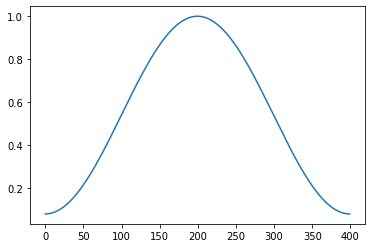

In [55]:
window = np.array([0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1)) for n in range(frame_length)])
plt.plot(window)

In [56]:
frames *= np.array([0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1)) for n in range(frame_length)])

다음은 이해를 돕기 위해 `frame_length`가 10일 때 개별 해밍 윈도우값들을 확인한 것입니다.

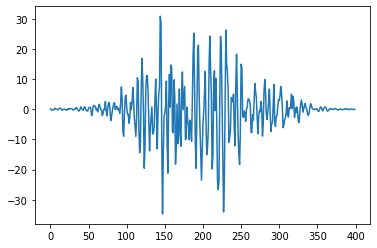

In [58]:
import matplotlib.pyplot as plt

plt.plot(frames[1])

---

## Fourer Transform

[푸리에 변환(Fourier Transform)](https://ratsgo.github.io/speechbook/docs/fe/ft)이란 시간(time) 도메인의 음성 신호를 주파수(frequency) 도메인으로 바꾸는 과정을 가리킵니다. 이산 푸리에 변환(Dicrete Fourier Transform)이란 이산 신호(discrete signal)에 대한 푸리에 변환을 가리키는데요. 그 컨셉은 그림3과 같습니다. 다시 말해 입력 프레임 각각의 주파수 정보를 확인하는 과정입니다.

## **그림3** Dicrete Fourier Transform
<img src="https://i.imgur.com/IDTqr8E.png" width="400px" title="source: imgur.com" />

푸리에 변환을 실제로 적용할 때는 **고속 푸리에 변환(Fast Fourier Transform)**이라는 기법을 씁니다. 기존 푸리에 변환에서 중복된 계산량을 줄이는 방법입니다. 이는 파이썬 numpy 패키지에서 `np.fft.fft` 함수를 쓰면 됩니다. 코드6과 같습니다. `NFFT`는 주파수 도메인으로 변환할 때 몇 개의 구간(bin)으로 분석할지 나타내는 인자(argument)인데요. 보통 256이나 512를 쓴다고 합니다.

## **코드6** Dicrete Fourer Transform

In [59]:
NFFT = 512
dft_frames = np.fft.rfft(frames, NFFT)

그런데 코드6에 실제 사용한 이산 푸리에 변환 함수는 `np.fft.rfft`인데요. 푸리에 변환 결과는 켤레 대칭이기 때문에 `np.fft.fft` 함수의 변환 결과에서 켤레 대칭인 파트 계산을 생략한 것이 `np.fft.rfft`의 계산 결과입니다. 따라서 `np.fft.fft`의 리턴 shape은 `num_frames × NFFT`, `np.fft.rfft`의 리턴 shape은 `num_frames × NFFT / 2 + 1`이 됩니다. 다음은 이해를 돕기 위해 프레임 하나([0.2, 0.7, 0.5, 0.3, 0.1])에 대해 이산 푸리에 변환을 수행한 것입니다.

In [60]:
np.fft.fft([0.2, 0.7, 0.5, 0.3, 0.1])

array([ 1.8+0.j        , -0.2-0.68819096j, -0.2-0.16245985j,
       -0.2+0.16245985j, -0.2+0.68819096j])

In [61]:
np.fft.rfft([0.2, 0.7, 0.5, 0.3, 0.1])

array([ 1.8+0.j        , -0.2-0.68819096j, -0.2-0.16245985j])


`np.fft.fft`를 쓰든 `np.fft.rfft`를 쓰든 이후 계산해볼 멜 스펙트럼, 로그 멜 스펙트럼, MFCC 계산 결과가 달라지지 않습니다(단 전자의 경우 Filter Bank의 필터 차원수가 `NFFT`, 후자는 `NFFT / 2 + 1`이 되어야 함). 계산량을 줄이려면 `np.fft.rfft`를 쓰는 것이 이득입니다.

---

## Magnitude

[이산 푸리에 변환](https://ratsgo.github.io/speechbook/docs/fe/ft#concepts)의 결과는 복소수(complex number)로 실수부(real part)와 허수부(imeginary part) 두 개로 나눠 생각해볼 수 있습니다. $j$는 제곱해서 -1이 되는 허수, $k$번째 주파수 구간(bin)에 해당하는 이산 푸리에 변환 결과를 $X[k]=a+b \times j$라고 할 때 이 주파수 성분의 진폭(magnitude)과 위상(phase)은 그림4와 같이 이해할 수 있습니다. 진폭은 이 주파수 성분의 크기를, 위상은 해당 주파수의 (복소평면상 단위원상)위치를 나타낸다고 해석할 수 있다는 이야기입니다.

## **그림4** Magnitude와 Phase
<img src="https://i.imgur.com/HTD1vC2.png" width="400px" title="source: imgur.com" />

그림4에서 진폭이 $\sqrt { { a }^{ 2 }+{ b }^{ 2 } }$이 되는 것은 피타고라스 정리를 활용해 유도할 수 있습니다. arctan 함수(=${ \tan }^{-1}$)에 탄젠트 값을 넣으면 각도가 리턴되는데요. ${ \tan   }^{ -1 }\left( \frac { b }{ a }  \right)$는 탄젠트 값이 $a/b$인 $\theta$를 가리킵니다. 어쨌든 **MFCC를 구할 때는 음성 인식에 불필요한 위상 정보는 없애고 진폭 정보만을 남깁니다.** 코드7을 수행하면 됩니다. `np.absolute` 함수는 복소수 입력($a+b \times j$)에 대해 $\sqrt { { a }^{ 2 }+{ b }^{ 2 } }$를 리턴합니다.

## **코드7** Magnitude

In [63]:
mag_frames = np.absolute(dft_frames)
print(mag_frames.shape)

(348, 257)


---

## Power Spectrum

$k$번째 주파수 구간(bin)에 해당하는 이산 푸리에 변환 결과를 $X[k]$라고 할 때 파워(Power)를 구하는 공식은 수식3, 코드8과 같습니다($N$은 이산 푸리에 변환의 `NFFT`에 대응). 진폭(magnitude)의 제곱을 $N$으로 나눠준 값입니다. 이산 푸리에 변환 결과(스펙트럼)에 수식3을 적용한 결과를 **파워 스펙트럼(Power Spectrum)**이라고 합니다. 

## **수식3** Power

$$\text{Power}=\frac { { \left| X\left[ k \right]  \right|  }^{ 2 } }{ N }$$

## **코드8** Power Spectrum

In [66]:
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
pow_frames

array([[4.56436784e+00, 9.61376617e+00, 1.28494684e+01, ...,
        1.28758264e+00, 1.05667583e+00, 1.05136971e+00],
       [3.66161481e+01, 3.13583390e+01, 1.63059188e+01, ...,
        1.65000107e-01, 9.07508120e-02, 5.33055091e-02],
       [8.43883608e-02, 1.24688168e+00, 5.81277075e+00, ...,
        4.79126078e-01, 2.74198589e-01, 2.26308174e-01],
       ...,
       [1.47988174e+01, 2.25259499e+01, 2.10417914e+01, ...,
        5.96435148e+01, 3.28857267e+01, 3.26305170e+01],
       [9.50632323e-01, 5.75630844e+00, 2.20688176e+00, ...,
        8.64522389e+02, 2.99803916e+02, 7.87565828e+01],
       [1.89889057e+01, 1.83635086e+01, 1.02893503e+01, ...,
        1.27732593e+02, 5.30132716e+01, 4.88793937e+00]])

진폭을 구하든 파워를 구하든 복소수 형태인 이산 푸리에 변환 결과는 모두 실수(real number)로 바뀝니다. 다음은 코드5 수행 결과(이산 푸리에 변환)와 코드6 결과(파워 스펙트럼)를 비교한 것입니다.

In [65]:
dft_frames

array([[  48.34207625+0.00000000e+00j,  -26.42495684-6.49920760e+01j,
         -19.35232241+7.87681117e+01j, ...,
         -25.53478812-2.68643025e+00j,   -1.19394688+2.32291308e+01j,
          23.20132091+0.00000000e+00j],
       [-136.92139281+0.00000000e+00j,   83.32137111+9.54621323e+01j,
           9.70135027-9.08543573e+01j, ...,
          -9.14375956+9.33657150e-01j,    6.81515127-1.34643818e-01j,
          -5.22421484+0.00000000e+00j],
       [   6.57319106+0.00000000e+00j,   -4.423272  -2.48764564e+01j,
         -33.89939497+4.27430654e+01j, ...,
          -7.11349679-1.39538781e+01j,   -7.53909601+9.14066240e+00j,
          10.76428285+0.00000000e+00j],
       ...,
       [  87.04593332+0.00000000e+00j,  -76.31689303-7.55580453e+01j,
           0.47465627+1.03793891e+02j, ...,
          -9.45409371-1.74493839e+02j, -119.7415913 +4.99944334e+01j,
         129.25488261+0.00000000e+00j],
       [ -22.06181655+0.00000000e+00j,   44.98353263+3.03926260e+01j,
          26.76516102-

---

## Filter Banks

사람의 소리 인식은 1000Hz 이하의 저주파수(low frequency) 영역대가 고주파수(high frequency) 대비 민감하다고 합니다. 이에 주파수 영역대별 에너지 정보가 있는 데이터(`pow_frames`)에서 저주파수 영역대를 고주파수 영역대 대비 상대적으로 세밀하게 볼 필요가 있습니다. 이때 적용하는 기법을 **필터뱅크(Filter Banks)**라고 합니다. 

필터뱅크는 **멜 스케일(Mel Scale)** 필터를 쓰게 되는데요. 기존 주파수($f$, 단위는 헤르츠/Hz)를 멜($m$, 단위는 멜/mel)로, 멜을 헤르츠로 변환하는 공식은 수식4와 같습니다. 헤르츠 단위 주파수 $k$를 멜 단위 주파수 $m$에 대응시키는 필터를 만드는 공식은 수식5와 같습니다. 수식5의 필터를 파이썬으로 만드는 코드는 코드9와 같습니다. 수식4, 수식5, 코드9는 보기만 해도 머리가 아픈데요. 일단은 그렇구나 하고 바로 다음으로 넘어갑시다.

## **수식4** Mel vs Herz

$$
\begin{align*}
m &= 2595 \log_{10} (1 + \frac{f}{700}) \\
f &= 700 (10^{m/2595} - 1)
\end{align*}
$$

## **수식5** Mel Scale Filter

$$
H_m(k) =
  \begin{cases}
      \hfill 0                                      \hfill & k < f(m - 1) \\
      \\
      \hfill \dfrac{k - f(m - 1)}{f(m) - f(m - 1)}  \hfill & f(m - 1) \leq k < f(m) \\
      \\
      \hfill 1                                      \hfill & k = f(m) \\
      \\
      \hfill \dfrac{f(m + 1) - k}{f(m + 1) - f(m)}  \hfill & f(m) < k \leq f(m + 1) \\
      \\
      \hfill 0                                      \hfill & k > f(m + 1) \\
  \end{cases}
$$


## **코드9** Mel Scale Filter

In [67]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

코드9에서 멜 스케일 필터를 40개(`nfilt`) 쓰기로 정했습니다. 다음은 이 가운데 첫번째와 마지막 필터를 파이썬 콘솔에서 확인해본 것입니다. 각 필터의 길이는 `NFFT / 2 + 1`(257)입니다(이산 푸리에 변환을 `np.fft.fft` 함수로 수행했다면 `NFFT`).

In [68]:
len(fbank[0])

257

In [69]:
len(fbank[39])

257

In [70]:
fbank[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [71]:
fbank[39]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

코드10은 `pow_frames`에 필터 뱅크 기법을 적용합니다. 앞서 만든 `fbank`와 내적(inner product)를 수행하는 것인데요. 이를 앞의 `fbank[0]`, `fbank[39]`와 연관지어 이해해 봅시다. `fbank[0]`와 `pow_frames`를 내적하면 이산 푸리에 변환으로 분석된 257개 주파수 영역대 가운데 2번째 주파수 구간(bin)만 남기고 모두 무시합니다. `fbank[39]`와 `pow_frames`를 내적하면 257개 주파수 영역대 가운데 226~256번째 구간만 남기고 모두 무시하는데요. `fbank[39]`의 각 요소값은 해당 주파수 구간을 얼마나 살필지 가중치 역할을 담당하게 됩니다. 

요컨대 **`fbank[0]`는 헤르츠 기준 저주파수 영역대를 세밀하게 살피는 필터이고, `fbank[39]`는 고주파수 영역대를 넓게 보는 필터**라는 이야기입니다. 이는 그림4에서도 확인할 수 있습니다. 각 삼각형의 아랫변 범위가 각 멜 스케일 필터가 담당하는 헤르츠 기준 주파수 영역대입니다. 저주파수 영역대는 촘촘하게, 고주파수 영역대는 듬성듬성 보고 있습니다. 한편 코드10의 두번째 줄은 필터 뱅크 수행 결과가 0인 곳에 작은 숫자를 더해줘서 numerical problem을 예방하는 방어 장치입니다.

## **코드10** Filter Banks

In [72]:
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability

## **그림4** Mel scale filters
<img src="https://i.imgur.com/vuMPDsy.jpg" title="source: imgur.com" />

---

## Log-Mel Spectrum

사람의 소리 인식은 로그(log) 스케일에 가깝다고 합니다. 다시 말해 사람이 두 배 큰 소리라고 인식하려면 실제로는 에너지가 100배 큰 소리여야 한다는 이야기입니다. 우리는 인간의 말소리 인식에 중요한 특질을 추출하는 데 관심이 있으므로 멜 스펙트럼에 로그 변환을 수행하게 됩니다. `filter_banks`에 코드11과 같이 적용합니다.

## **코드11** Log-Filter Banks

In [73]:
filter_banks = 20 * np.log10(filter_banks)  # dB

코드11까지 모두 수행한 결과는 다음과 같습니다. 로그를 취하기 전의 음성 피처를 **멜 스펙트럼(Mel Spectrum)**, 로그까지 적용한 음성 피처를 **로그 멜 스펙트럼(Log-Mel Spectrum)**이라고 합니다. 멜 스펙트럼, 로그 멜 스펙트럼 모두 수행 이후의 차원 수는 `num_frames × nfilt`입니다.

In [74]:
filter_banks

array([[19.6578711 , 24.08243444, 13.28362604, ..., 37.41129385,
        35.12449152, 43.85294179],
       [29.92706103, 25.02887464,  4.56447493, ..., 29.99648702,
        27.63755602, 31.12405847],
       [ 1.91650485, 20.62599882, 27.84652515, ..., 33.67880595,
        33.86877509, 35.21519583],
       ...,
       [27.05366229, 35.49493867, 80.35178791, ..., 82.34780355,
        60.26241633, 71.50671916],
       [15.20288113, 33.00403036, 80.75428113, ..., 76.87788039,
        71.14996413, 82.2580797 ],
       [25.27911327, 34.40468846, 80.88589194, ..., 85.26351843,
        67.78637171, 74.19285132]])

In [75]:
filter_banks.shape

(348, 40)

---

## MFCCs

멜 스펙트럼 혹은 로그 멜 스펙트럼은 태생적으로 피처(feature) 내 변수 간 상관관계(correlation)가 존재합니다. 그도 그럴 것이 멜 스케일 필터(수식5, 코드9)를 보면 주변 몇 개의 헤르츠 기준 주파수 영역대 에너지를 한데 모아 보기 때문입니다. 다시 말해 헤르츠 기준 특정 주파수 영역대의 에너지 정보가 멜 스펙트럼 혹은 로그 멜 스펙트럼의 여러 차원에 영향을 주는 구조입니다. 이는 변수 간 독립(independence)을 가정하고 모델링하는 [가우시안 믹스처 모델(Gaussian Mixture Model)](https://ratsgo.github.io/speechbook/docs/am/gmm#modeling-speech-recognition)에는 독이 될 수 있습니다.

로그 멜 스펙트럼에 역푸리에 변환(Inverse Fourier Transform)을 수행해 변수 간 상관관계를 해소한 피처를 **Mel-frequency Cepstral Coefficients(MFCCs)**라고 합니다. 로그 멜 스펙트럼에 역푸리에 변환을 실시하면 상관관계가 높았던 주파수 도메인 정보가 새로운 도메인으로 바뀌어 이전 대비 상대적으로 변수 간 상관관계가 해소되게 됩니다. 

MFCCs를 만들 때는 코드12처럼 역이산 코사인 변환(Inverse Discrete Cosine Transform)을 씁니다. 코사인 변환은 푸리에 변환에서 실수 파트만을 수행합니다. 마지막으로 MFCCs의 shape은 `num_frames × nfilt`인데요. 이 행렬 가운데 2-13번째 열벡터들만 뽑아서 최종적인 MFCCs 피처로 사용하게 됩니다. 이외 주파수 영역대 정보들은 만들 때마다 워낙 빠르게 바뀌어 음성 인식 시스템 성능 향상에 도움이 되지 않기 때문이라고 합니다.

## **코드12** Mel-frequency Cepstral Coefficients

In [78]:
from scipy.fftpack import dct
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

멜 스펙트럼 혹은 로그 멜 스펙트럼 대비 MFCCs는 구축 과정에서 버리는 정보가 지나치게 많습니다. 이 때문인지 최근 딥러닝 기반 모델들에서는 MFCCs보다는 멜 스펙트럼 혹은 로그 멜 스펙트럼 등이 더 널리 쓰이는 듯 합니다.

결과적으로 최종적으로 만들어진 MFCCs는 다음과 같습니다. 그 shape은 `num_frames × num_ceps(12)`입니다.

In [79]:
mfcc.shape

(348, 12)

In [80]:
mfcc

array([[-69.3685124 , -73.11219282,   5.67513949, ...,  -1.16277698,
          0.65669277,  -3.93879587],
       [-52.33524779, -66.52306496,   9.53491011, ...,   8.42687174,
         -0.67383872,  16.95492264],
       [-47.45887971, -61.18738131,  -1.48740623, ...,   2.11518642,
         -0.14992889,  -9.62792944],
       ...,
       [ -7.5666849 , -44.75050146,  -4.24933718, ..., -17.64169325,
        -11.47970976, -21.09783305],
       [-15.00786239, -43.48311676, -10.23308666, ..., -14.63322634,
        -19.71501677, -19.55306183],
       [ -7.83738597, -45.7707345 ,  -5.61861348, ..., -20.3951281 ,
        -10.11722731, -23.15458664]])

---

## Post Processing

MFCCs를 입력으로 하는 음성 인식 시스템의 성능을 높이기 위해 몇 가지 후처리를 하기도 합니다. 대표적으로 Lift, Mean Normalization 등이 있습니다. 전자는 MFCCs에, 후자는 멜 스펙트럼 혹은 로그 멜 스펙트럼에 실시합니다. 각각 코드13, 코드14와 같습니다.

## **코드13** Lift

In [81]:
(nframes, ncoeff) = mfcc.shape
cep_lifter = 22
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift

(12,)


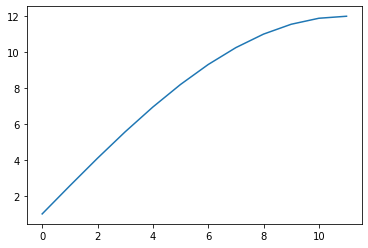

In [83]:
print(lift.shape)
plt.plot(lift)

## **코드14** Mean Normalization

In [84]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

In [85]:
filter_banks.shape

(348, 40)

---

## References

- [Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)
- [김형석, Mel-Frequency Cepstral Coefficients, 모두의연구소 음성인식 부트캠프, 2020. 2. 1.](https://home.modulabs.co.kr/product/%ec%9d%8c%ec%84%b1-%ec%9d%b8%ec%8b%9d-%eb%b6%80%ed%8a%b8%ec%ba%a0%ed%94%84)
- [MFCC(Mel-Frequency Cepstral Coefficients) 이해하기](https://brightwon.tistory.com/11)

---